# Optimization of IEA case
`1000.26.Feb.20`

## Explanation

Having not yet completed the mapping algorithm, I need to move ahead with a simpler optimization. I'll divide the space into vertical slices, and make a switch statement to see what zone we''re in, and if it's valid. Below will be the code for that.

## Load area and split

In [2]:
#- Rip the boundary coordinates from the .yaml file and print -#
from scipy.optimize import minimize
import scipy.spatial.distance as ssd
import random

%run "baker_cs34_functions_sandbox.py"
%run "iea37_aepcalc.py"
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)
coordList = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary

-10.650319260075621


In [4]:
#-- Plot the boundary (modelled with splines) --#
displaySize = np.recarray(1, coordinate)
displaySize.x = 10
displaySize.y = 10
numLinspace = 10
numGridLines = 10                   # How many gridlines we'll use for the visualization
printOffset = (5, 5)
clsdBP = closeBndryList(bndryPts)
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)

scaleAEP = 1e5
scaleTurbCoord = 1e3

#-- Spline the boundary --#
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
print("The splined boundary and the defining coordinates:")
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 1)

#for i in vertexList:                         # Number the vertices
for i in range(len(clsdBP)):                         # Number the vertices
    plt.plot(clsdBP[i].x, clsdBP[i].y, 'o', color=(getPltClrs().getColor(5)))
    plt.annotate(i, (clsdBP[i].x, clsdBP[i].y), xytext=printOffset, textcoords='offset points')


The splined boundary and the defining coordinates:


TypeError: printBoundaryArray() takes 3 positional arguments but 4 were given

In [5]:
#-- Split into vertical sections
def getVertSectionLines(bndryPts, splineList, vertexList):
    #-- Print the windfarm boundary, sliced at coordinates.
    #-- bndryPts must be <np.ndarray> of type <coordinate>
    
    #- Make array of lines -#
    buf = np.zeros((len(bndryPts)-1, 2, 2), dtype=coordinate)                # Start and end point for each coordinate's verticale line
    regionLines = np.recarray((len(bndryPts)-1, 2), dtype=coordinate, buf=buf)  # Initialize some blank lines
    # Outside vertecies are themselves
    regionLines[0,0].x = bndryPts[0].x
    regionLines[0,0].y = splineList[0](bndryPts[0].x)
    regionLines[0,1] = regionLines[vertexList[0],0]

    # points 1-6
    for i in range(vertexList[0]+1, vertexList[1]+1):
        # Start point
        regionLines[i,0].x = bndryPts[i].x
        regionLines[i,0].y = bndryPts[i].y
        # End point
        regionLines[i,1].x = regionLines[i,0].x
        regionLines[i,1].y = splineList[3](bndryPts[i].x)

    # point 7
    for i in range(vertexList[1]+1, vertexList[2]):
        # Start point
        regionLines[i,0].x = bndryPts[i].x
        regionLines[i,0].y = bndryPts[i].y
        # End point
        regionLines[i,1].x = regionLines[i,0].x
        regionLines[i,1].y = splineList[2](bndryPts[i].x)
        
    # Outside vertex is itself
    regionLines[vertexList[2],0].x = bndryPts[8].x
    regionLines[vertexList[2],0].y = bndryPts[8].y
    regionLines[vertexList[2],1] = regionLines[vertexList[2],0]

    # points 8-12
    for i in range(vertexList[2]+1, 13):
        # Start point
        regionLines[i,0].x = bndryPts[i].x
        regionLines[i,0].y = bndryPts[i].y
        # End point
        regionLines[i,1].x = regionLines[i,0].x
        regionLines[i,1].y = splineList[1](bndryPts[i].x)
    
    # points 13-17
    for i in range(13, vertexList[4]):
        # Start point
        regionLines[i,0].x = bndryPts[i].x
        regionLines[i,0].y = bndryPts[i].y
        # End point
        regionLines[i,1].x = regionLines[i,0].x
        regionLines[i,1].y = splineList[0](bndryPts[i].x)
    
    # Sort so it's from left to right instead of clockwise around the boundary
    regionLines.sort(axis=0)
    
    return regionLines


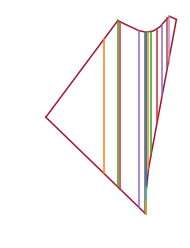

In [9]:
#-- Print the new splits --#
# Reprint Boundary
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), 1)

# Calculate and split into sections (the new thing)
regionLines = getVertSectionLines(coordList, splineList, vertexList)
for i in range(len(regionLines)):
    plt.plot([regionLines[i,0].x, regionLines[i,1].x], [regionLines[i,0].y, regionLines[i,1].y])
    #plt.annotate(i, xy=(regionLines[i,0].x, regionLines[i,0].y), xytext=printOffset, textcoords='offset points')
plt.savefig("./figures/cs3slices.pdf")

`1308.26.Feb.20`

Well that took much longer than expected, but now I've sectioned it off into segments.

`1332.26.Feb.20`

I next ordered them from left to right instead of in clockwise order of originating vertex, and will use those for the optimization.

## Setup optimization and constraints
`1412.26.Feb.20`

Now I'll have to learn pyoptsparse or some Python optimizer to find some good turbine locaitons.

### Coordinate Formatting
`1412.26.Feb.20`

Listing the constraints, we have:

1. Turbines can't be within two diametes of each other
2. Stepping between each of the 17 x-regions, must be above or below bounding lines.

I'll have to write some quick fuctions that strip the coordinate values from <coord> types to a list of numbers for the optimizer to modify.

In [74]:
def makeCoordArray(turb_coords):
    # Takes coordinates in form turb_coords.x and .y and flattens them into a
    # single array. For optimizer to use.
    x0 = np.dstack((turb_coords.x, turb_coords.y)).flatten()
    return x0

def makeCoordStruct(x0):
    # Takes coordinates in an [x1,y1,x2,y2...] line and puts them into the form turb_coords.x and .y
    # For optimzer use.
    nNumRtrs = int(len(x0)/2)
    coordList = np.recarray(nNumRtrs, coordinate)
    
    coordMat = x0.reshape((nNumRtrs, 2))
    coordList.x = coordMat[:,0]
    coordList.y = coordMat[:,1]
    
    return coordList

def makeCoordMatrix(x0):
    # Makes an Mx2 matrix where [0,1] = [x,y]
    # For scipy.spatial.distance.pdist() function
    nNumRtrs = int(len(x0)/2)
    coordMat = x0.reshape((nNumRtrs, 2))
    return coordMat

def makeFirstCoordStruct(turb_coords):
    # Takes ripped .yaml coordinates and puts them into our struct format.
    # Only needs to be done once at the beginning.
    nNumRtrs = len(turb_coords)
    coordList = np.recarray(nNumRtrs, coordinate)
    
    coordList.x = turb_coords[:, 0]
    coordList.y = turb_coords[:, 1]

    return coordList

### Target Function Format
`2002.26.Feb.20`

Now that both of those work, I need to figure out how to get the target function in the correct format.

In [203]:
def optimoFun(x0, args):
    [wind_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr] = optimoStripArgTuples(args)
    newCoords = makeCoordMatrix(x0) * scaleTurbCoord
    
    dirAEP = calcAEPcs3(newCoords, wind_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr)
    scaledAEP = dirAEP / scaleAEP
    return -np.sum(scaledAEP)
    #return np.sum(dirAEP)
    
def optimoStripArgTuples(args):
    # Takes the passed array and strips items into their proper variables.
    cntr = 0
    wind_dir_freq_len = int(args[0])
    cntr = cntr + 1
    wind_dir_freq = args[cntr:(wind_dir_freq_len + cntr)]
    cntr = cntr + wind_dir_freq_len    
    wind_speeds_len = int(args[cntr])
    cntr = cntr + 1
    wind_speeds = args[cntr:(wind_speeds_len + cntr)]
    cntr = cntr + wind_speeds_len
    wind_speed_prob_len = int(args[cntr])
    cntr = cntr + 1
    wind_speed_prob_wid = int(args[cntr])
    cntr = cntr + 1
    wind_speed_prob_size = wind_speed_prob_len * wind_speed_prob_wid
    wind_speed_probs = args[cntr:(wind_speed_prob_size + cntr)]
    wind_speed_probs = wind_speed_probs.reshape(wind_speed_prob_len, wind_speed_prob_wid)
    cntr = cntr + wind_speed_prob_size
    wind_dir_len = int(args[cntr])
    cntr = cntr + 1
    wind_dir = args[cntr:(wind_dir_len + cntr)]
    cntr = cntr + wind_dir_len
    turb_diam = float(args[cntr])
    cntr = cntr + 1
    turb_ci = float(args[cntr])
    cntr = cntr + 1
    turb_co = float(args[cntr])
    cntr = cntr + 1
    rated_ws = float(args[cntr])
    cntr = cntr + 1
    rated_pwr = float(args[cntr])
    cntr = cntr + 1
        
    return [wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir,
            turb_diam, turb_ci, turb_co, rated_ws, rated_pwr]

def optimoMakeArgTuples(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr):
    # Takes the list of passed variables and concatenates them into one long array with size markers for matricies
    wind_speed_probs_size = len(wind_speed_probs) * len(wind_speed_probs[0])
    argLen = len(wind_dir_freq) \
                + len(wind_speeds) \
                + wind_speed_probs_size \
                + len(wind_dir) \
                + 4 \
                + 6 # 4 For lengths of first four entries
                # 5 For single element items <turb_diam, turb_ci, turb_co, rated_ws, rated_pwr>
    
    args = np.zeros(argLen)
    cntr = 0  # Where we are right now.

    args[0] = len(wind_dir_freq)
    cntr = cntr + 1
    args[cntr:(len(wind_dir_freq)+cntr)] = wind_dir_freq
    cntr = cntr + len(wind_dir_freq)
    args[cntr] = len(wind_speeds)
    cntr = cntr + 1
    args[cntr:len(wind_speeds)+cntr] = wind_speeds
    cntr = cntr + len(wind_speeds)
    args[cntr] = len(wind_speed_probs)
    cntr = cntr + 1
    args[cntr] = len(wind_speed_probs[0])
    cntr = cntr + 1
    args[cntr:wind_speed_probs_size+cntr] = np.asarray(wind_speed_probs).reshape(-1)
    cntr = cntr + wind_speed_probs_size
    args[cntr] = len(wind_dir)
    cntr = cntr + 1
    args[cntr:len(wind_dir)+cntr] = wind_dir
    cntr = cntr + len(wind_dir)
    args[cntr] = turb_diam
    cntr = cntr + 1
    args[cntr] = turb_ci
    cntr = cntr + 1
    args[cntr] = turb_co
    cntr = cntr + 1
    args[cntr] = rated_ws
    cntr = cntr + 1
    args[cntr] = rated_pwr
    
    return args

#-- Verify --#
testArgs = optimoMakeArgTuples(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr)
#testx1 = makeFirstCoordStruct(turb_coords)
testx0 = makeCoordArray(turbRandoList)
#print(turb_coords)
#testx0 = makeCoordMatrix(turb_coords)
testAEP = optimoFun(testx0, testArgs)
print(testAEP)


-10.65041097342426


It took some work, but those functions to smash all the arguments together and pull them back again now work. They need to be in a single tupled list for `scipy.optimize()` to work.

Now to figure out how to setup the constraints.

### Random Turbine Starts
`2340.26.Feb.20`

Ok I figured out how to calculate the spacing constraints (that no turbine is within two diameters of another):

-9.73917812734508


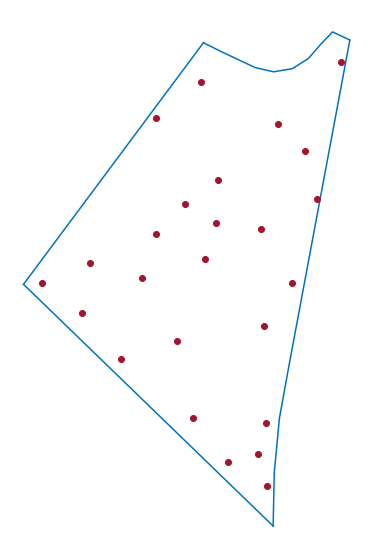

In [204]:
def iea37cs3randomstarts(numTurbs, splineList, vertexList, bndryPts, turb_diam):
    #-- Initialize our array --#
    buf = np.zeros((numTurbs,2))
    turbRandoList = np.recarray((numTurbs), dtype=coordinate, buf=buf)
    minTurbDist = 2*turb_diam

    #-- Get the x-values --#
    xmin = bndryPts[vertexList[2]].x   # Our minimum x-value
    xmax = bndryPts[vertexList[0]].x   # our maximum x-value
    for i in range(numTurbs):
        turbRandoList[i].x = random.uniform(xmin, xmax)

    #-- Get the y-values --#
    #- Determine the upper and lower splines to use for the given x -#
    # Fake for-loop here for proximity checking.
    i = 0
    while i<numTurbs:
        ymin,ymax = getUpDwnYvals(turbRandoList[i].x, splineList, vertexList, bndryPts)
        turbRandoList[i].y = random.uniform(ymin, ymax) # Get a random number in our bounds
        # Check it doesn't conflict with nearby turbines
        for j in range(i): # Check only the ones we've place so far
            # If this turbine has a proximity conflict
            if (coordDist(turbRandoList[i], turbRandoList[j]) < minTurbDist):
                turbRandoList[i].x = random.uniform(xmin, xmax) # Give it a new x-val
                i = i-1 # Redo the y-val too
                break # Stop checking for conflicts and redo the y-values
        i = i+1

    return turbRandoList

def getUpDwnYvals(xCoord, splineList, vertexList, bndryPts):
    # Given there are 4 splines (with 0&1 below, 2&3 above),
    # returns the indecies of splines the given x-coord falls between
    
    #-- Upper. If it's out of bounds
    if (xCoord < bndryPts[vertexList[2]].x):
        ymax = bndryPts[vertexList[2]].y # Give it the y-value of our leftmost point
    # If it's to the left of the right upper spline
    elif (xCoord < bndryPts[vertexList[3]].x):
        ymax = splineList[2](xCoord)  # Make it the left upper spline
    # If it's to the left of the rightmost point
    elif (xCoord < bndryPts[vertexList[0]].x):
        ymax = splineList[3](xCoord)  # Make it the left upper spline
    else:
        ymax = bndryPts[vertexList[0]].y # Give it the y-value of our rightmost point

    #-- Lower. If it's to the left of the right lower spline
    if (xCoord < bndryPts[vertexList[2]].x):
        ymin = bndryPts[vertexList[2]].y # Give it the y-value of our leftmost point
    elif (xCoord < bndryPts[vertexList[1]].x):
        ymin = splineList[1](xCoord) # Make it the left upper spline
    elif (xCoord < bndryPts[vertexList[0]].x):
        ymin = splineList[0](xCoord)
    else:
        ymin = bndryPts[vertexList[0]].y # Give it the y-value of our rightmost point
    
    return ymin,ymax

#-- Testing --#
numTurbs = 25
turbRandoList = iea37cs3randomstarts(numTurbs, splineList, vertexList, bndryPts, turb_diam)

#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/2)
x0 = makeCoordArray(turbRandoList)/scaleTurbCoord
startAEP = optimoFun(x0, Args)
print(startAEP)

### Spacing Constraint
`2255.26.Feb.20`

In [131]:
def checkTurbSpacing(x0, turb_diam):
    testCoordMat = makeCoordMatrix(x0)           # make [[x1,y1],[x2,y2],...]

    cTurbSpace = ssd.pdist(testCoordMat, metric='euclidean') # Get the distance between each turbine
    constraints = cTurbSpace - (2*turb_diam)                 # Constrain that the turbines are less than 2 diams apart
    return constraints  # Negative if ok, positive if too close

#-- Validation --#
x0 = makeCoordArray(turbRandoList)                # get it into a long array of [x1,y1,x2,y2,...]
consTurbSpacing = checkTurbSpacing(x0, turb_diam)
print(consTurbSpacing)


[3487.88557269  453.60145177 1536.56669199 2117.20811221 2956.20405118
  191.93478909 4698.97446549 3185.50519047 3550.44855504 2342.13401372
 2726.67216129 1348.1120185  2024.19089482 2730.99733723 2773.39491121
  707.88887531 3393.80765674 2813.21153666 1516.95695783 1098.87302188
 4230.56651494 1134.38678094 4191.62732163 2563.09435735 3189.65224768
 1622.01875969  974.68051513  685.14117367 2939.86926211 4864.12133366
 1981.03230051 4201.38294898  860.01331883  413.70256729 1773.94477682
 1535.82107881 2539.43964208 3918.66590713 3617.03841053 4538.44873563
 1233.71944739 3453.899382   3044.11957523 4649.64446422 3605.10260342
 4082.71877042  724.13116057 1174.2288363  1869.61349998 2464.41577584
  193.09346025 3856.52955172 2451.36922449 2712.57249657 2215.60042937
 2516.87148016 1282.80415449 1452.27497694 1923.06512579 1945.8176381
   97.40282845 2589.35464203 2210.68809947  696.2863315   250.0773334
 3392.84179776  388.6146985  3342.03675568 2140.73180962  318.24764836
 1035.92

I figured out how to randomize the starting coordinates of the turbines:

`0050.27.Feb.20`

Actually had to rework that since it was having a spacing issue and generating turbines which violated the spacing constraint. I also made the check of `getUpDownYvals()` a seperate function for use elsewhere. Though it took an hour, I finally got that sorted out.

### Boundary Constraints
`2340.26.Feb.20`

Now I have to do the boundary constraints.

Though it might be the sleep deprevation talking but I think that, like the random start function, I may only need to figure out which spline the turbine's x-coord falls under and over, and then it'll be easy to determine if it's in or out. I don't see how a gradient based optimizer will have difficulty with this, unless the boundary involves non-injective functions, which cs3 scenario does not.

In [163]:
def checkBndryCons(x0, splineList, vertexList, bndryPts):
    turbList = makeCoordStruct(x0)

    # Check to make sure our poits are in
    bndryCons = np.zeros(numTurbs*4)   # four values (two x and two y) for every turbine
    xmin = bndryPts[vertexList[2]].x   # Our minimum x-value
    xmax = bndryPts[vertexList[0]].x   # our maximum x-value
    
    # For every turbine
    for i in range(numTurbs):
        #- Check x-vals
        bndryCons[4*i] = (xmax - turbList[i].x)   # Positive good, neg bad
        bndryCons[4*i+1] = (turbList[i].x - xmin) # pos good, neg bad
        
        #- Check y-vals
        ymin,ymax = getUpDwnYvals(turbList[i].x, splineList, vertexList, bndryPts)
        bndryCons[4*i+2] = (ymax - turbList[i].y)
        bndryCons[4*i+3] = (turbList[i].y - ymin)
            
    return bndryCons

#- Test check -#
x0 = makeCoordArray(turbRandoList)
#x0 = res.x
bBndryCons = checkBndryCons(x0, splineList, vertexList, bndryPts)
print(bBndryCons) # Should all be positive

[1.46790111e+03 2.79759889e+03 2.24299494e+02 5.42665055e+03
 1.17149458e+03 3.09400542e+03 2.26766473e+03 3.54698436e+03
 1.85290454e+03 2.41259546e+03 5.03242612e+03 4.31718372e+02
 2.52724059e+03 1.73825941e+03 2.70027104e+03 1.31714093e+03
 7.04775444e+02 3.56072456e+03 4.00311285e+02 3.02414785e+03
 8.34247793e+02 3.43125221e+03 3.28064686e+03 7.99153659e+02
 2.48457769e+03 1.78092231e+03 3.92396251e+03 1.92050639e+02
 3.55322686e+03 7.12273140e+02 1.48948026e+03 1.56703631e+02
 2.12470382e+03 2.14079618e+03 2.40991114e+03 2.53782503e+03
 3.63556278e+03 6.29937221e+02 9.86675447e+02 4.69216187e+02
 1.54280494e+02 4.11121951e+03 1.67036612e+02 7.30515994e+02
 2.63072346e+03 1.63477654e+03 2.09665703e+03 1.68158850e+03
 3.79316459e+03 4.72335405e+02 4.03726711e+02 6.87920428e+02
 3.38311352e+03 8.82386480e+02 6.98198997e+02 1.34114564e+03
 4.12847804e+03 1.37021961e+02 3.15858856e+02 8.22108045e-01
 4.03528744e+02 3.86197126e+03 1.04978963e+03 1.02590529e+03
 1.13998611e+03 3.125513

`0122.26.Feb.20`

It seems both the boundary and spacing constraints are complete, being `<=0` if they are valid, and `>0` if they are invalid. Now I need to code up the actual optimization.

### Optimization Code

"Main" function:

`1130.27.Feb.20`

After discussion at lab meeting, the boundary constraints need to be non-binary. It's not giving the optimizer any gradients to work with.

In [205]:
fn = "iea37-ex-opt3.yaml"
turb_coords, fname_turb, fname_wr = getTurbLocYAML(fn)
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = getTurbAtrbtYAML(fname_turb)
#test = makeFirstCoordStruct(turb_coords)     # Strip it from the .yaml
#x0 = makeCoordArray(test)                    # get it into a long array of [x1,y1,x2,y2,...]
#testCoordMat = makeCoordMatrix(x0)           # make [[x1,y1],[x2,y2],...]
x0 = makeCoordArray(turbRandoList)/scaleTurbCoord
startAEP = optimoFun(x0, Args)
print(startAEP)

#-- Setup the optimization --#
#- args in the correct format -#
Args = optimoMakeArgTuples(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr)
#- Constraints in the correct format -#
#bBndryCons = checkBndryCons(x0, splineList, vertexList, bndryPts)
#consTurbSpacing = checkTurbSpacing(x0, turb_diam)
cons = ({'type': 'ineq', 'fun': lambda x:  checkBndryCons(x*scaleTurbCoord, splineList, vertexList, bndryPts)},{'type': 'ineq', 'fun': lambda x: checkTurbSpacing(x*scaleTurbCoord, turb_diam)})
res = minimize(optimoFun, x0, args=Args, method='SLSQP', constraints=cons, options={'disp': True,'maxiter':1000})


-9.73917812734508
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10.216052284892044
            Iterations: 52
            Function evaluations: 2761
            Gradient evaluations: 52


[ 6117.00606815 10363.8         7069.18999838  7475.24942745
  6602.43514728  6565.538907    7722.27317691  8947.68648022
  9983.89648741  8592.48067542  9414.11859132  9993.75786795
  8974.3964913   9106.21797188  8607.78965868  9893.04597135
  6908.59319501  8847.73415213  9625.01683116  7818.05005635
  8319.42393156  7634.51695318  7370.60100717  9733.84878879
  9361.26606671  3322.61480527  6490.3         3644.71932966
  5146.19511141  3040.81618141  3799.48930596  3748.73744801
  2390.7174995   4458.78664276   881.73707724  1238.79167421
  4951.03965396  4334.41847433   649.16653528  6303.20192542
  4038.22312224  2512.67645367  4745.08359597  5596.36188254
  1885.9243547   1398.16860483  3559.4489361   5005.69392874
  3121.67018322   137.19294606]
-10.650413978710757


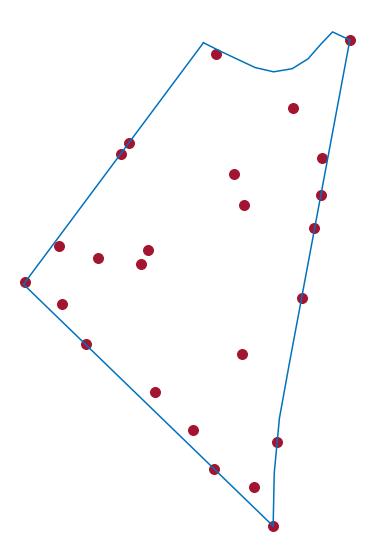

In [206]:
finalTurbLoc = makeCoordStruct(res.x*scaleTurbCoord)

#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#-- Plot the turbine locations --#
printTurbines(finalTurbLoc, getPltClrs().getColor(1), turb_diam/2)
#plt.plot(finalTurbLoc.x, finalTurbLoc.y, 'o', color=(getPltClrs().getColor(1)))

print(res.x)
print(optimoFun(res.x, Args))

Another try:

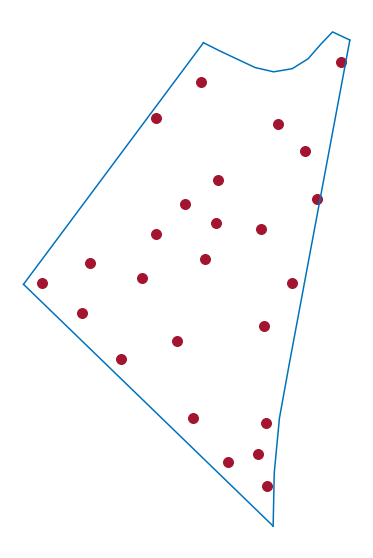

In [207]:
#- Test check -#
#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/2)

-10.650319260075621


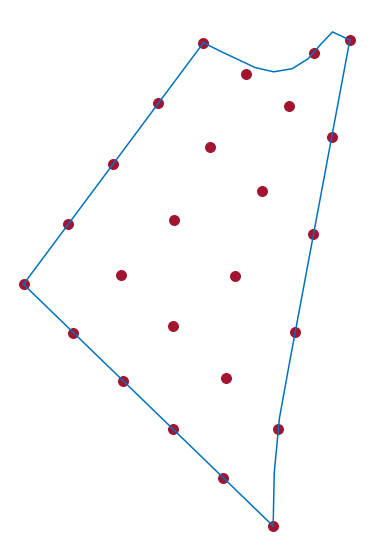

In [212]:
#- Test check -#
#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#-- Plot the turbine locations --#
test = makeFirstCoordStruct(turb_coords)     # Strip it from the .yaml
test1 = makeCoordArray(test)
printTurbines(test, getPltClrs().getColor(1), turb_diam/2)
print(optimoFun(test1, Args))

`1000.02.Mar.201`

I've gotten it working well enough, I'm going to close this notebook, move everything over to a standalone python file, and try and optimize it from there.